# Demo Notebook Feature Engineering

# Initializing

## load packages and set constants

In [1]:
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time
import importlib
import re
import math
import itertools
import operator
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 60)
plt.rcParams["figure.figsize"] = (30, 15)
#plt.style.use('ggplot')
sns.set_style('whitegrid')

random_seed = 999

In [2]:
dict_model = {}
dict_model['LR'] = 'Logistic Regression'
dict_model['RF'] = 'Random Forest Classifier'
dict_model['AB'] = 'AdaBoost Classifier'
dict_model['EN'] = 'ElasticNet'
dict_model['SVC'] = 'C-Support Vector Classification'
dict_model['SGD'] = 'Stochastic Gradient Descent'
dict_model['kNN'] = 'Nearest Neighbors Classification'
dict_model['GPC'] = 'Gaussian Process Classification'
dict_model['DT'] = 'Decision Tree Classifier'
dict_model['GB'] = 'Gradient Boosting Classifier'

time: 42.4 ms


## Functions

In [3]:
def score_MCC(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    with np.errstate(divide='ignore',invalid='ignore'):
        mcc = ((tp * tn) -(fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    return tp, fp, tn, fn, mcc

def load_madelon(local=True):
    if local:
        #URLS for dataset included in package
        train_data_url='data/madelon/madelon_train.data'
        train_label_url='data/madelon/madelon_train.labels'
        test_data_url='data/madelon/madelon_valid.data'
        test_label_url='data/madelon/madelon_valid.labels'
    else:
        # URLS for dataset via UCI
        train_data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
        train_label_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'
        test_data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.data'
        test_label_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.labels'
    
    X_data = pd.read_csv(train_data_url, sep=" ", header=None)
    y_data = pd.read_csv(train_label_url, sep=" ", header=None)
    data = X_data.iloc[:,0:500]
    data['target'] = y_data[0]
    X_test = pd.read_csv(test_data_url, sep=" ", header=None)
    y_test = pd.read_csv(test_label_url, sep=" ", header=None)
    test = X_test.iloc[:,0:500]
    test['target'] = y_test[0]
    return data, test

def run_alg(dict_alg, X_train, X_test, y_train, y_test):
    col_names = ['algorithm', 'TP', 'FP', 'TN', 'FN', 'MCC']
    df = pd.DataFrame(columns=col_names)
    for key in dict_alg.keys():
        model = dict_alg[key]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # handling the continuos results and forcing them to binary
        if key in ['EN']:
            y_pred = [1 if i >=0 else -1 for i in y_pred]
        df = df.append(pd.DataFrame([dict(zip(col_names,[dict_model[key]] + list(score_MCC(y_test, y_pred))))]), ignore_index=True)
    return df[col_names] # forcing right layout

def run_tune_alg(dict_alg, dict_param, X_train, X_test, y_train, y_test):
    col_names = ['algorithm', 'TP', 'FP', 'TN', 'FN', 'MCC']
    df = pd.DataFrame(columns=col_names)
    for key in dict_alg.keys():
        print(key)
        model = dict_alg[key]
        param_grid = dict_param[key]
        grid_search = GridSearchCV(model, param_grid=param_grid)
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        if key in ['EN']:
            y_pred = [1 if i >=0 else -1 for i in y_pred]
        df = df.append(pd.DataFrame([dict(zip(col_names,[dict_model[key]] + list(score_MCC(y_test, y_pred))))]), ignore_index=True)
    return df[col_names] # forcing right layout

def prep_data(X, y, random_seed):
    return train_test_split(X, y, test_size=0.33, random_state=random_seed)

def prep_df(df_train, df_test):
    X_train = df_train.iloc[:,:-1]
    y_train = df_train.iloc[:,-1]
    X_test = df_test.iloc[:,:-1]
    y_test = df_test.iloc[:,-1]
    return X_train, X_test, y_train, y_test

time: 169 ms


## Loading Data Sets

In [4]:
df_train, df_test = load_madelon()

time: 373 ms


In [5]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,target
0,485,477,537,479,452,471,491,476,475,473,455,500,456,507,478,491,447,422,480,482,515,482,464,484,477,496,509,491,459,482,...,470,515,476,467,401,485,499,495,490,508,463,487,531,515,476,482,463,467,479,477,481,477,485,511,485,481,479,475,496,-1
1,483,458,460,487,587,475,526,479,485,469,434,483,465,503,472,478,469,518,495,491,478,530,462,494,549,469,516,487,475,486,...,478,465,479,482,549,470,506,481,494,492,448,492,447,598,507,478,483,492,485,463,478,487,338,513,486,483,492,510,517,-1
2,487,542,499,468,448,471,442,478,480,477,468,497,477,491,493,502,465,567,510,475,474,483,490,492,544,482,454,496,491,495,...,481,485,478,479,454,503,501,500,484,479,470,466,529,482,486,487,480,522,481,487,481,492,650,506,501,480,489,499,498,-1
3,480,491,510,485,495,472,417,474,502,476,455,520,437,472,481,436,503,522,488,468,492,488,476,479,477,485,506,476,472,506,...,481,457,476,481,602,500,503,481,487,465,473,477,515,525,468,487,458,489,490,491,480,474,572,454,469,475,482,494,461,1
4,484,502,528,489,466,481,402,478,487,468,432,494,493,434,505,497,486,471,467,476,455,517,483,465,512,552,505,464,472,419,...,476,500,479,483,560,474,486,459,494,509,456,472,520,468,482,473,473,498,485,488,479,452,435,486,508,481,504,495,511,1


time: 108 ms


In [6]:
df_train.shape

(2000, 501)

time: 134 ms


In [7]:
df_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,target
0,483,454,513,495,523,469,453,477,506,479,470,510,463,423,511,500,494,493,472,477,497,503,474,472,483,538,454,468,490,510,...,469,454,477,472,538,509,488,493,487,499,486,462,523,432,484,474,458,485,464,455,480,543,259,413,520,485,498,523,510,-1
1,485,508,493,487,478,472,504,476,479,475,533,495,427,456,482,481,471,466,476,476,485,470,490,488,504,490,483,478,491,490,...,476,439,478,481,429,481,493,501,492,480,465,474,528,472,483,472,492,469,468,486,480,535,534,514,452,484,495,548,477,-1
2,483,521,507,475,493,486,421,475,496,483,428,481,477,578,480,477,458,516,482,467,466,499,479,476,512,547,457,461,479,474,...,478,494,478,486,517,478,494,462,495,503,502,462,462,507,480,472,446,508,477,491,476,498,495,508,528,486,465,508,503,-1
3,474,504,576,480,553,483,524,478,483,483,467,547,484,430,489,492,476,481,443,486,508,492,484,468,559,465,491,503,472,485,...,481,540,477,485,386,477,469,474,484,485,506,493,465,562,478,474,498,482,481,521,475,470,463,509,525,479,467,552,517,1
4,495,474,523,479,495,488,485,476,497,478,510,479,514,446,470,487,480,441,467,485,474,502,492,476,460,505,481,506,469,457,...,482,487,478,471,527,519,478,520,478,470,455,500,488,480,495,481,498,495,464,510,471,522,343,509,520,475,493,506,491,-1


time: 104 ms


In [8]:
df_test.shape

(600, 501)

time: 34 ms


# Setting up stack of algorithms

- Logistic Regression
- Random Forest
- Ada Boost
- Elastic Net
- SVC (rbf kernel)
- Stochastic Gradient Descent
- Nearest Neighbors Classification
- Gaussian Process Classification (GPC)
- Decision Tree
- Gradient Boosting Classifier

In [9]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 45.2 ms


## scoring via Matthews Correlation Coefficient (MCC):

for more details refer https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

$
MCC = \frac{TP \times TN – FP \times FN}{\sqrt{ (TP +FP) \times (TP + FN) \times (TN + FP) \times (TN + FN)}}
$

## output from each algorithm to be captured:

| algorithm | TP | FP | TN | FN | MCC |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | | | | | |
| Random Forest | | | | | |
| Ada Boost | | | | | |
| Elastic Net | | | | | |
| SVC (rbf kernel) | | | | | |
| Stochastic Gradient Descent | | | | | |
| Nearest Neighbors Classification | | | | | |
| Gaussian Process Classification (GPC) | | | | | |
| Decision Tree | | | | | | 

# Reducing DataSet

## Running Boruta

In [10]:
from boruta import BorutaPy

def borutas_rank(li_dum_feat, ranking_):
    dict_rank = dict(zip(li_dum_feat, ranking_))
    ranked = sorted(dict_rank.items(), key=operator.itemgetter(1))
    for i in range(len(ranked)):
        if ranked[i][1] == 1:
            print('Confirmed {:>3}: {}'.format(ranked[i][1], ranked[i][0]))
        else:
            print('Rejected {:>4}: {}'.format(ranked[i][1], ranked[i][0]))

X_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:,-1].ravel()
X_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:,-1].ravel()
li_dum_feat = list(df_train.iloc[:,:-1].columns.values)
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=1)
feat_selector.fit(X_train,y_train)
X_train = feat_selector.transform(X_train)
X_test = feat_selector.transform(X_test)
borutas_rank(li_dum_feat, feat_selector.ranking_)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

## Closer look at the selection
Comment: I have evaluated the burota package used above in-depth. Although I agree with the principle idea in the paper (but I think it does not constitute a universally viable and usable solution), I take issue with the ACTUAL implementation: The packages presented, apart from having un-fixed bugs and poor maintenance do not follow the algorithm and logic laid out in the academic paper. The result is an approximation that does a more or less close guess of what the actual paper asks for.<br>
**So let's have a closer look:**

In [11]:
def borutas_confirmed(li_dum_feat, ranking_):
    dict_rank = dict(zip(li_dum_feat, ranking_))
    ranked = sorted(dict_rank.items(), key=operator.itemgetter(1))
    result = []
    for i in range(len(ranked)):
        if ranked[i][1] == 1:
            result += [ranked[i][0]]
    return result
li_keep = borutas_confirmed(li_dum_feat, feat_selector.ranking_)
li_target = ['target']


time: 39.2 ms


In [12]:
df_explore = df_train[li_keep + li_target].copy()

time: 65.9 ms


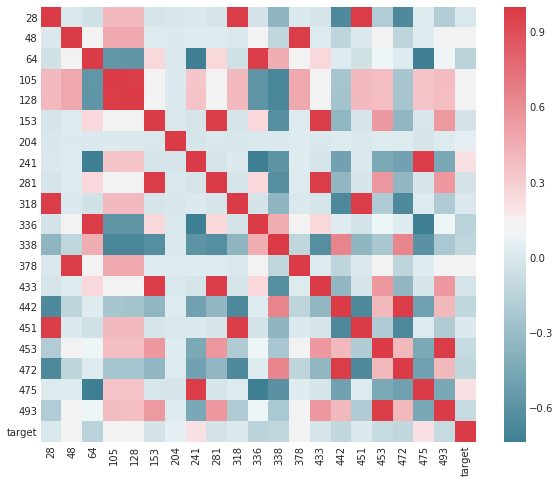

time: 677 ms


In [13]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_explore.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

Yes, the odd one that does not belong is feature 204. But knowing a bit about this dataset, I know that there are 20 features in it that carry signal. So let's run a baseline model fit for a start.

## Setting Baseline

In [14]:
df_base = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 5.8 s


In [15]:
df_base

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,175,119,181,125,0.186704
1,Random Forest Classifier,264,36,264,36,0.760000
2,AdaBoost Classifier,198,123,177,102,0.250615
3,ElasticNet,179,118,182,121,0.203344
4,C-Support Vector Classification,2,0,300,298,0.057831
5,Stochastic Gradient Descent,300,300,0,0,NaN
6,Nearest Neighbors Classification,266,37,263,34,0.763372
7,Gaussian Process Classification,4,0,300,296,0.081923
8,Decision Tree Classifier,256,55,245,44,0.670451
9,Gradient Boosting Classifier,248,58,242,52,0.633460


time: 65.3 ms


## Diving deeper

In [16]:
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]
model = RandomForestClassifier(random_state=random_seed)
model.fit(X, y)

dict_rank = dict(zip(li_dum_feat, model.feature_importances_))
ranked = sorted(dict_rank.items(), key=operator.itemgetter(1))

dic_top = ranked[-30:]

time: 315 ms


In [17]:
dic_top

[(326, 0.0043743811091274702),
 (342, 0.004392572238136239),
 (278, 0.0043946488729463499),
 (45, 0.004401840213279949),
 (389, 0.0044353502928818987),
 (344, 0.0045144348635325973),
 (108, 0.0046220156420849132),
 (140, 0.0046357174533606105),
 (427, 0.0046647413335699061),
 (481, 0.0048679308986957995),
 (431, 0.005090092243996096),
 (434, 0.005594778806843251),
 (472, 0.0057183232520326656),
 (281, 0.0057307057213648229),
 (493, 0.0058081235656055078),
 (453, 0.0058391723602477562),
 (64, 0.0067001194971565937),
 (451, 0.0069999614047553714),
 (318, 0.0072034489585373358),
 (455, 0.0073330518611686383),
 (336, 0.0081585056893605512),
 (48, 0.0086445393948557034),
 (442, 0.0092396534918066184),
 (475, 0.0093723482182482588),
 (378, 0.0094064154818299522),
 (28, 0.0098226505157841155),
 (128, 0.011334410374096575),
 (338, 0.020204571457461944),
 (105, 0.021293717052790533),
 (241, 0.022774417333280238)]

time: 36.8 ms


Most in here are "old" customers. After some back-and forth, it is clear that '455' is valuable, but was rejected by the boruta package (actually as 5th feature to be rejected).<br>
So lets do the correlation matrix agian without 204 but with 455:

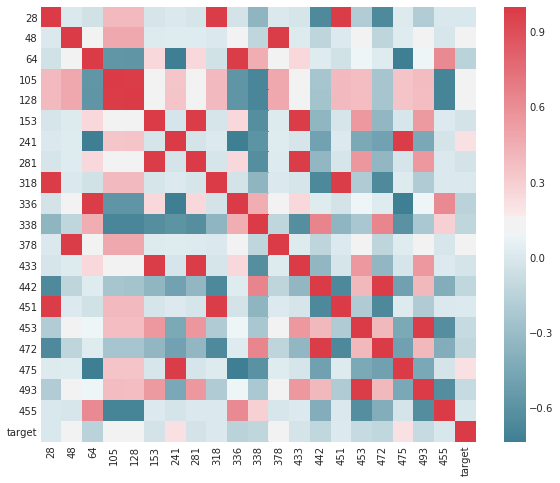

time: 799 ms


In [18]:
li_keep.remove(204)
li_keep += [455]
df_explore = df_train[li_keep + li_target].copy()
f, ax = plt.subplots(figsize=(10, 8))
corr = df_explore.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

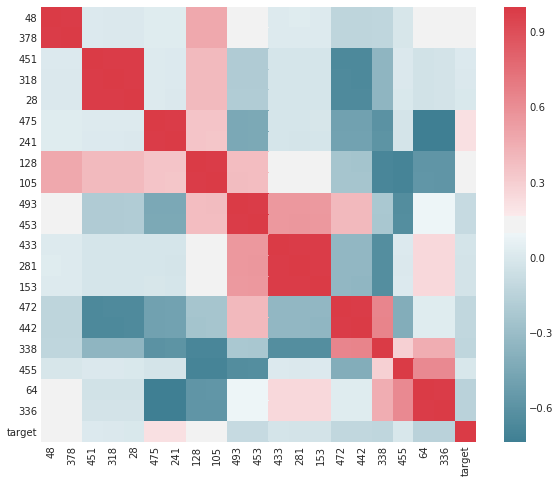

time: 875 ms


In [19]:
li_seq = [48, 378, 451, 318, 28, 475, 241, 128, 105, 493, 453, 433, 281, 153, 472, 442, 338, 455, 64, 336, 'target']
df_train_sml = df_train[li_seq].copy()
df_test_sml = df_test[li_seq].copy()
f, ax = plt.subplots(figsize=(10, 8))
corr = df_train_sml.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

In [20]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
df_deeper = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 5.66 s


In [21]:
df_deeper

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,175,122,178,125,0.176676
1,Random Forest Classifier,260,36,264,40,0.746733
2,AdaBoost Classifier,200,103,197,100,0.323350
3,ElasticNet,180,119,181,120,0.203334
4,C-Support Vector Classification,1,0,300,299,0.040859
5,Stochastic Gradient Descent,229,218,82,71,0.042062
6,Nearest Neighbors Classification,272,34,266,28,0.793492
7,Gaussian Process Classification,7,0,300,293,0.108648
8,Decision Tree Classifier,255,58,242,45,0.657284
9,Gradient Boosting Classifier,245,54,246,55,0.636670


time: 69.5 ms


So let's have a closer look at these features:

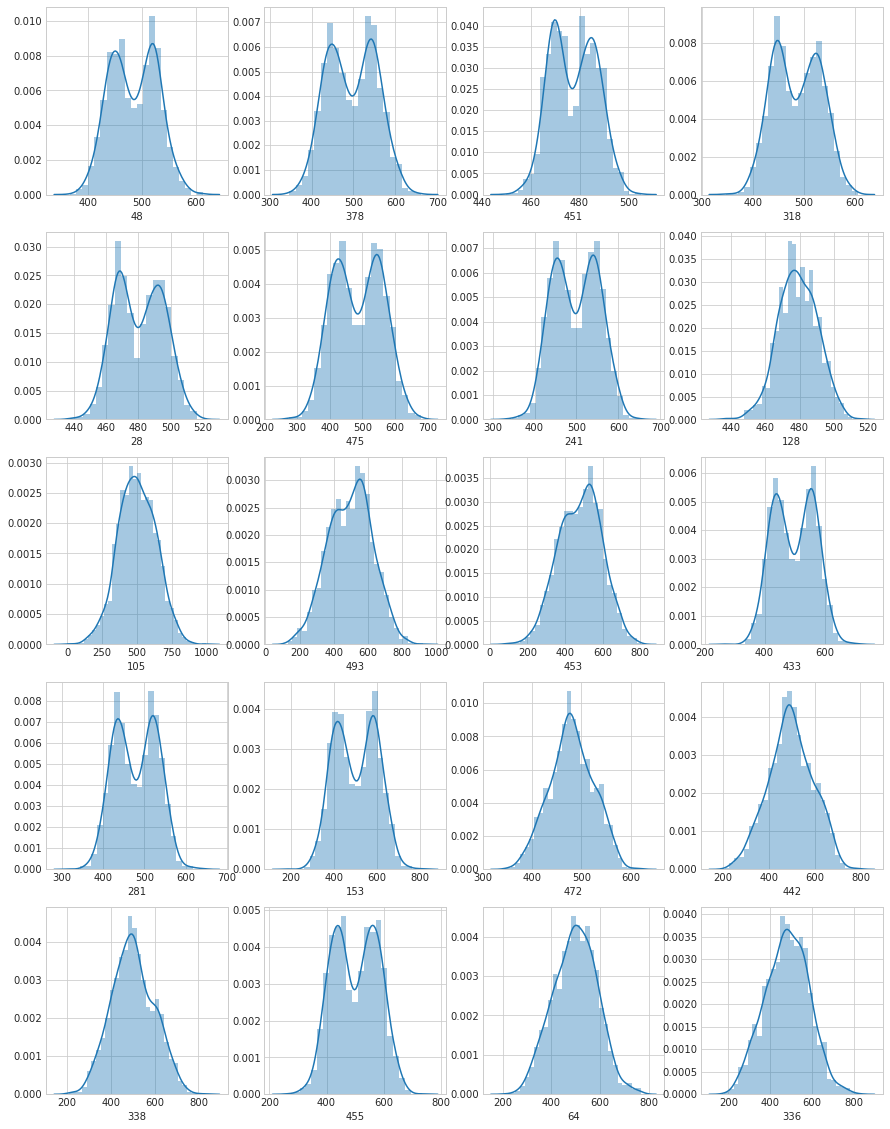

time: 6.05 s


In [22]:
fig = plt.figure(figsize = (15, 20))
for i, col in enumerate(X_train.columns):
    plt.subplot(5, 4, 1+i)
    sns.distplot(X_train[col])

This figure shows the normalized histograms of the 20 relevant features. Most features show relatively normal or bimodal distribution.

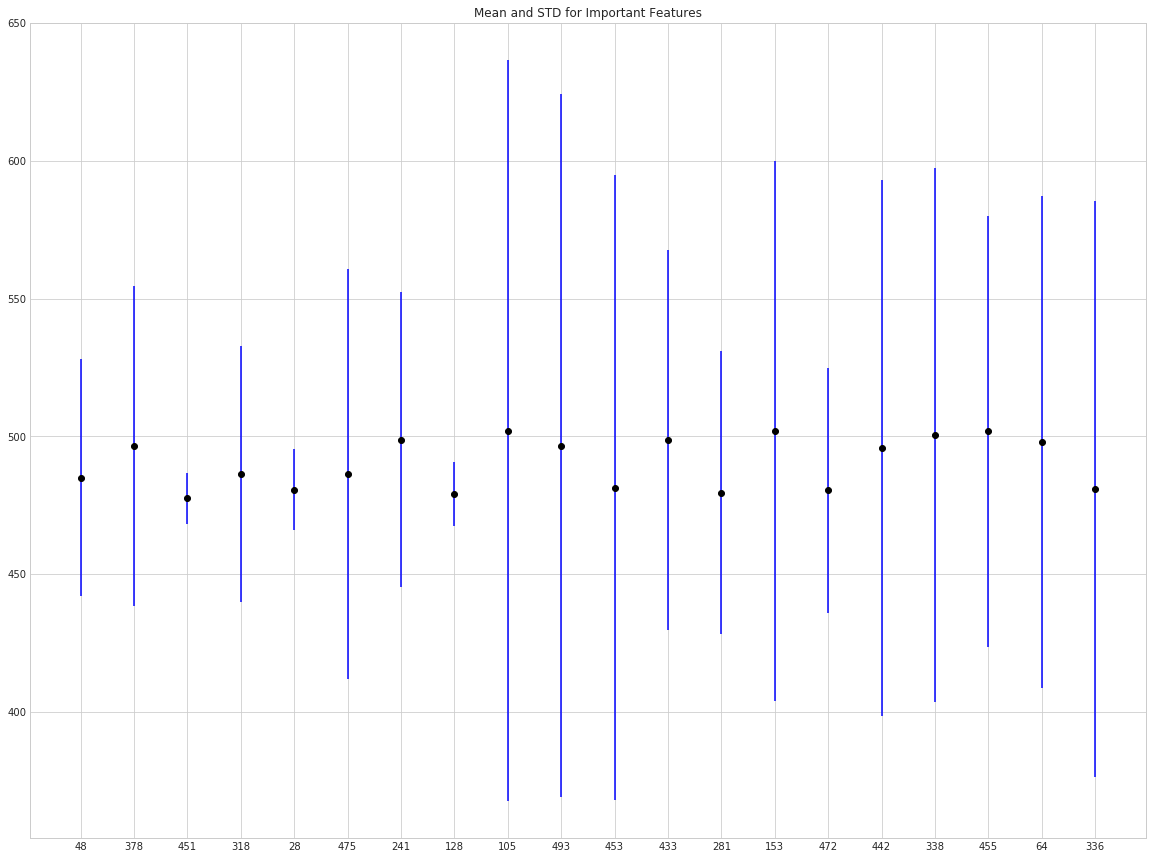

time: 838 ms


In [23]:
fig = plt.figure(figsize = (20, 15))
plt.errorbar(range(20), X_train.mean(), yerr=X_train.std(), fmt='ko', ecolor='b')
plt.xticks(range(20), X_train.columns)
plt.title('Mean and STD for Important Features')
plt.show();

This figure shows the means plotted with their standard deviations of the 20 features. While the means fall within a fairly small range, the standard deviations vary greatly between features.

# Feature Engineering 1st step

As above graphs show, the scale of the features varies greatly. Alo, the mean of all features is roughly between 480 and 510. The target is either 1 or -1.<br>
This imbalance in values, amplitude and mean can be a factor deteriorating the results. So it is good practice to scale the values.

## Scaling the features

### StandardScaler

In [24]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

time: 33.9 ms


In [25]:
df_StdScaler = run_alg(dict_alg, X_train_scale, X_test_scale, y_train, y_test)

time: 7.78 s


In [26]:
df_StdScaler

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,177,119,181,123,0.193351
1,Random Forest Classifier,260,38,262,40,0.740016
2,AdaBoost Classifier,200,103,197,100,0.323350
3,ElasticNet,300,300,0,0,NaN
4,C-Support Vector Classification,261,49,251,39,0.707060
5,Stochastic Gradient Descent,153,142,158,147,0.036672
6,Nearest Neighbors Classification,278,30,270,22,0.826961
7,Gaussian Process Classification,283,25,275,17,0.860306
8,Decision Tree Classifier,254,58,242,46,0.653857
9,Gradient Boosting Classifier,245,54,246,55,0.636670


time: 51.8 ms


Particular of interest here is that the Gaussian Process (GPC) comes in really high. This is starting to look interesting, considering the shape of the dataset.

### MinMaxScaler

In [27]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

time: 34.6 ms


In [28]:
df_MinMaxScaler = run_alg(dict_alg, X_train_scale, X_test_scale, y_train, y_test)

time: 7.76 s


In [29]:
df_MinMaxScaler

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,180,116,184,120,0.213352
1,Random Forest Classifier,261,36,264,39,0.750038
2,AdaBoost Classifier,200,103,197,100,0.323350
3,ElasticNet,300,300,0,0,NaN
4,C-Support Vector Classification,196,74,226,104,0.408715
5,Stochastic Gradient Descent,232,229,71,68,0.011851
6,Nearest Neighbors Classification,282,32,268,18,0.834242
7,Gaussian Process Classification,260,50,250,40,0.700389
8,Decision Tree Classifier,255,59,241,45,0.654046
9,Gradient Boosting Classifier,245,54,246,55,0.636670


time: 52.1 ms


Seems like both scalers have the positive sides, this means we might want to consider running both in comparission on the next steps.

# Feature Engineering 2nd step:

I know about this dataset that it consists of five original features that get transformed, noise added, then made redundant, out of these ten are randomly selected (with replacement) for duplication, followed by additional manipulation and noise overlay.<br>
Bottom line is the dataset has five dimensions. So let's use PCA to reduce the 20 features to 5 dimensions:

## PCA without scaler:

In [30]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
pca = PCA(n_components=5)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

time: 76.3 ms


In [31]:
df_pca_none = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 5.12 s


In [32]:
df_pca_none

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,178,122,178,122,0.186667
1,Random Forest Classifier,253,31,269,47,0.741055
2,AdaBoost Classifier,190,108,192,110,0.273339
3,ElasticNet,177,119,181,123,0.193351
4,C-Support Vector Classification,0,0,300,300,NaN
5,Stochastic Gradient Descent,137,158,142,163,-0.070010
6,Nearest Neighbors Classification,271,38,262,29,0.777016
7,Gaussian Process Classification,45,1,299,255,0.275625
8,Decision Tree Classifier,245,66,234,55,0.597068
9,Gradient Boosting Classifier,251,56,244,49,0.650177


time: 49.6 ms


## PCA with Standard Scaler:

In [33]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=5)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

time: 73 ms


In [34]:
df_pca_std = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 7.46 s


In [35]:
df_pca_std

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,178,123,177,122,0.183334
1,Random Forest Classifier,259,36,264,41,0.743437
2,AdaBoost Classifier,197,107,193,103,0.300027
3,ElasticNet,300,300,0,0,NaN
4,C-Support Vector Classification,280,28,272,20,0.840299
5,Stochastic Gradient Descent,184,141,159,116,0.143834
6,Nearest Neighbors Classification,278,30,270,22,0.826961
7,Gaussian Process Classification,283,26,274,17,0.857052
8,Decision Tree Classifier,230,57,243,70,0.577209
9,Gradient Boosting Classifier,248,65,235,52,0.610574


time: 46.2 ms


## PCA with MinMax Scaler

In [36]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=5)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

time: 51.1 ms


In [37]:
df_pca_minmax = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 7.17 s


In [38]:
df_pca_minmax

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,178,123,177,122,0.183334
1,Random Forest Classifier,250,35,265,50,0.717564
2,AdaBoost Classifier,190,121,179,110,0.230155
3,ElasticNet,300,300,0,0,NaN
4,C-Support Vector Classification,230,53,247,70,0.590950
5,Stochastic Gradient Descent,255,261,39,45,-0.028820
6,Nearest Neighbors Classification,281,34,266,19,0.824364
7,Gaussian Process Classification,260,52,248,40,0.693889
8,Decision Tree Classifier,239,72,228,61,0.557041
9,Gradient Boosting Classifier,252,65,235,48,0.624337


time: 65.2 ms


# with Standard Scaler, PCA, Standard Scaler and tuned algorithm

In [39]:
X_train, X_test, y_train, y_test = prep_df(df_train_sml, df_test_sml)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=5)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
scaler2 = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler2.fit(X_train)
X_train = scaler2.transform(X_train)
X_test = scaler2.transform(X_test)

time: 81.3 ms


In [40]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=64, random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(decision_function_shape='ovo', C=1, gamma=.9, random_state=random_seed)
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier(algorithm='auto', leaf_size=2, n_neighbors=10, weights='distance')
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 40.7 ms


In [41]:
df_pca_tuned = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 12.1 s


In [42]:
df_pca_tuned

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,178,123,177,122,0.183334
1,Random Forest Classifier,268,40,260,32,0.760270
2,AdaBoost Classifier,197,107,193,103,0.300027
3,ElasticNet,300,300,0,0,NaN
4,C-Support Vector Classification,282,23,277,18,0.863453
5,Stochastic Gradient Descent,191,196,104,109,-0.017415
6,Nearest Neighbors Classification,281,29,271,19,0.840467
7,Gaussian Process Classification,279,36,264,21,0.811014
8,Decision Tree Classifier,230,57,243,70,0.577209
9,Gradient Boosting Classifier,248,65,235,52,0.610574


time: 48.9 ms


# Summary

| approach | best | runner-up | time|
| --- | --- | --- | --- | 
| baseline | 0.763 | 0.60 | < 10 sec. |
| modified features | 0.793 | 0.47 | < 10 sec.(\*) |
| Standard Scaler | 0.860 | 0.827 | < 10 sec. |
| MinMax Scaler | 0.834 | 0.750 | < 10 sec. |
| PCA | 0.777 | 0.741 | < 10 sec. |
| Std. Scaler, PCA | 0.857 | 0.840 | < 10 sec. |
| MinMax Scaler, PCA | 0.824 | 0.718 | < 10 sec. |
| Std. Scaler, PCA, Std. Scaler, tuned algo | 0.863 | 0.840 | < 15 sec.(\*\*) |

(\*) with manual preparation of a few minutes<br>
(\*\*) with manual effort to tune algorithm to demonstrate effort not worth the gains over Standard Scaler alone or Std. Sclr + PCA solution (with default algo)